**Кейс №2 - Приложение доставки**

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

- **ab_users_data** – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
- **ab_orders** – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
- **ab_products** – подробная информация о продуктах, их название и стоимость


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pingouin as pg
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

---


## Подготовка


In [6]:
ab_orders = pd.read_csv(r"data\ab_orders.csv", parse_dates=['creation_time'])
ab_products = pd.read_csv(r"data\ab_products.csv")
ab_users_data = pd.read_csv(
    r"data\ab_users_data.csv", parse_dates=['time', 'date'])

In [7]:
ab_orders['product_ids'] = ab_orders.product_ids.str.replace(
    '[{}]', '', regex=True)

ab_orders['product_ids'] = ab_orders.product_ids.str.split(', ')

ab_orders = ab_orders.explode('product_ids').rename(
    columns={'product_ids': 'product_id'})

ab_orders['product_id'] = ab_orders['product_id'].astype(int)

---


In [8]:
ab_orders.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56


In [9]:
ab_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13826 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       13826 non-null  int64         
 1   creation_time  13826 non-null  datetime64[ns]
 2   product_id     13826 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 378.1 KB


---


In [10]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [11]:
ab_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


---


In [12]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [13]:
ab_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   4337 non-null   int64         
 1   order_id  4337 non-null   int64         
 2   action    4337 non-null   object        
 3   time      4337 non-null   datetime64[ns]
 4   date      4337 non-null   datetime64[ns]
 5   group     4337 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 203.4+ KB


---


In [14]:
all_data = pd.merge(ab_orders, ab_users_data, on='order_id')
all_data = all_data.merge(ab_products, on='product_id', how='left')
all_data

,order_id,creation_time,product_id,user_id,action,time,date,group,name,price
0,1255,2022-08-26 00:00:19,75,964,create_order,2022-08-26 00:00:19,2022-08-26,0,сок ананасовый,120.0
1,1255,2022-08-26 00:00:19,22,964,create_order,2022-08-26 00:00:19,2022-08-26,0,сок мультифрукт,120.0
2,1255,2022-08-26 00:00:19,53,964,create_order,2022-08-26 00:00:19,2022-08-26,0,мука,78.3
3,1255,2022-08-26 00:00:19,84,964,create_order,2022-08-26 00:00:19,2022-08-26,0,мандарины,90.4
4,1256,2022-08-26 00:02:21,56,965,create_order,2022-08-26 00:02:21,2022-08-26,1,сосиски,150.0
...,...,...,...,...,...,...,...,...,...,...
14564,59487,2022-09-08 23:29:06,9,1461,create_order,2022-09-08 23:29:06,2022-09-08,0,чай черный листовой,83.5
14565,59487,2022-09-08 23:29:06,62,1461,create_order,2022-09-08 23:29:06,2022-09-08,0,сок яблочный,120.0
14566,59487,2022-09-08 23:29:06,77,1461,create_order,2022-09-08 23:29:06,2022-09-08,0,курица,298.4
14567,59533,2022-09-08 23:41:24,17,1376,create_order,2022-09-08 23:41:24,2022-09-08,0,морс брусничный,190.0


In [15]:
all_data.describe()

,order_id,creation_time,product_id,user_id,time,date,group,price
count,14569.000000,14569,14569.000000,14569.000000,14569,14569,14569.000000,14569.000000
mean,16444.676299,2022-08-30 15:09:49.116754688,43.406685,1465.626193,2022-08-30 15:10:07.387957248,2022-08-30 01:17:29.433729024,0.610337,111.425444
min,1255.000000,2022-08-26 00:00:19,1.000000,964.000000,2022-08-26 00:00:19,2022-08-26 00:00:00,0.000000,1.000000
25%,2462.000000,2022-08-26 20:24:17,24.000000,1219.000000,2022-08-26 20:24:17,2022-08-26 00:00:00,0.000000,50.000000
50%,9655.000000,2022-08-29 12:53:26,42.000000,1461.000000,2022-08-29 12:53:26,2022-08-29 00:00:00,1.000000,75.000000
75%,27165.000000,2022-09-02 21:13:39,66.000000,1711.000000,2022-09-02 21:13:39,2022-09-02 00:00:00,1.000000,120.400000
max,59533.000000,2022-09-08 23:41:24,87.000000,1980.000000,2022-09-08 23:41:24,2022-09-08 00:00:00,1.000000,800.000000
std,16655.039468,NaN,24.954329,291.173787,NaN,NaN,0.487691,107.561664


In [57]:
# Отмененные заказы
cancel_order = all_data.groupby(
    'order_id', as_index=0).agg({'action': 'unique'})
cancel_order = cancel_order[all_data.groupby('order_id', as_index=0).agg(
    {'action': 'unique'})['action'].apply(lambda x: len(x) > 1)]
cancel_order.head()

,order_id,action
3,1258,"[create_order, cancel_order]"
35,1296,"[create_order, cancel_order]"
37,1298,"[create_order, cancel_order]"
45,1308,"[create_order, cancel_order]"
51,1315,"[create_order, cancel_order]"


## Увеличился ли средний чек?


In [41]:
control_group = all_data.query("group == 0 and order_id not in 'cancel_order.order_id'").groupby(
    'user_id', as_index=0).agg({'price': 'sum'})
test_group = all_data.query("group == 1 and order_id not in 'cancel_order.order_id'").groupby(
    'user_id', as_index=0).agg({'price': 'sum'})

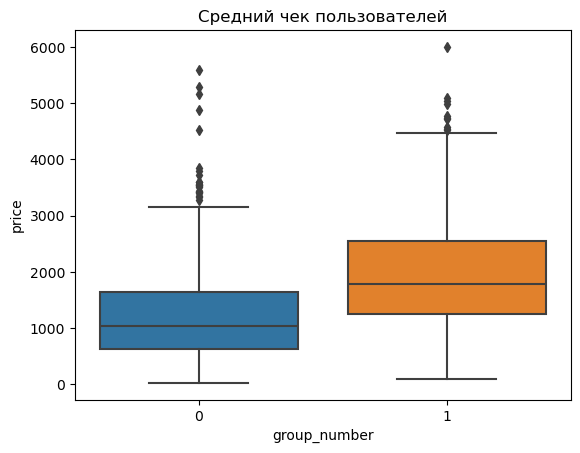

In [42]:
control_group['group_number'] = 0
test_group['group_number'] = 1

combined_df = pd.concat([control_group, test_group])

sns.boxplot(x=combined_df.group_number, y=combined_df.price).set_title(
    "Средний чек пользователей")

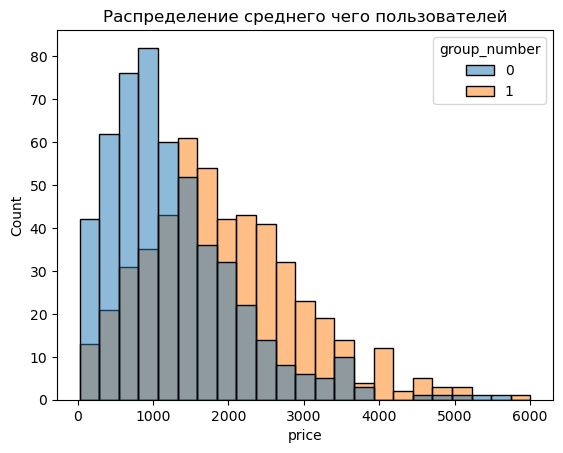

In [43]:
sns.histplot(x=combined_df.price, hue=combined_df.group_number).set_title(
    "Распределение среднего чего пользователей")

In [44]:
pg.ttest(x=test_group.price, y=control_group.price)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,11.662103,981.806998,two-sided,1.589864e-29,"[584.13, 820.48]",0.732931,1.897e+26,1.0


Мы получили значимые отличия между группами, новая система рекомендации увеличивает средний чек пользователя
на 549.71-769.93


## Изменилось ли соотношение заказов и отмен в тестовой группе?


In [45]:
control_group = all_data.query("group == 0")
test_group = all_data.query("group == 1")

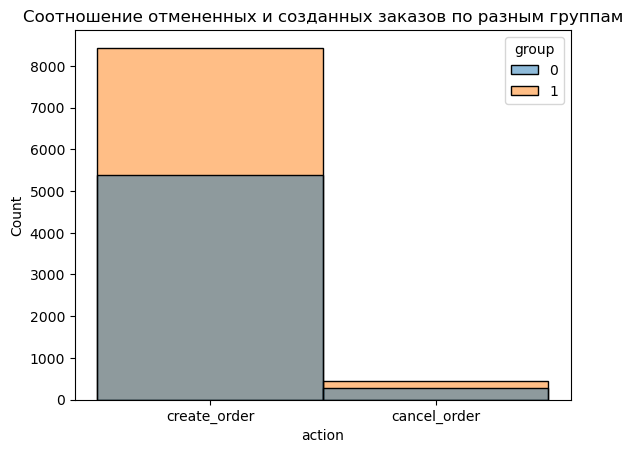

In [46]:
sns.histplot(x=all_data.action, hue=all_data.group).set_title(
    "Соотношение отмененных и созданных заказов по разным группам")

In [47]:
pg.chi2_independence(data=all_data,
                     x='group',
                     y='action')

(action  cancel_order  create_order
 group                             
 0         289.519596   5387.480404
 1         453.480404   8438.519596,
 action  cancel_order  create_order
 group                             
 0              287.5        5389.5
 1              455.5        8436.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  0.024323  1.0  0.876066  0.001292  0.052791
 1        cressie-read  0.666667  0.024329  1.0  0.876050  0.001292  0.052792
 2      log-likelihood  0.000000  0.024342  1.0  0.876017  0.001293  0.052793
 3       freeman-tukey -0.500000  0.024352  1.0  0.875992  0.001293  0.052794
 4  mod-log-likelihood -1.000000  0.024362  1.0  0.875967  0.001293  0.052795
 5              neyman -2.000000  0.024382  1.0  0.875917  0.001294  0.052798)

Тест Хи квадрат показывает, что число созданных и отмененных заказов не различаются по группам


## Изменился ли DAU?


In [48]:
dau = all_data.query("order_id not in 'cancel_order.order_id'").groupby(
    ['date', 'group'], as_index=0).agg({'user_id': 'count'})

dau.head()

,date,group,user_id
0,2022-08-26,0,2201
1,2022-08-26,1,2388
2,2022-08-27,0,423
3,2022-08-27,1,715
4,2022-08-28,0,324


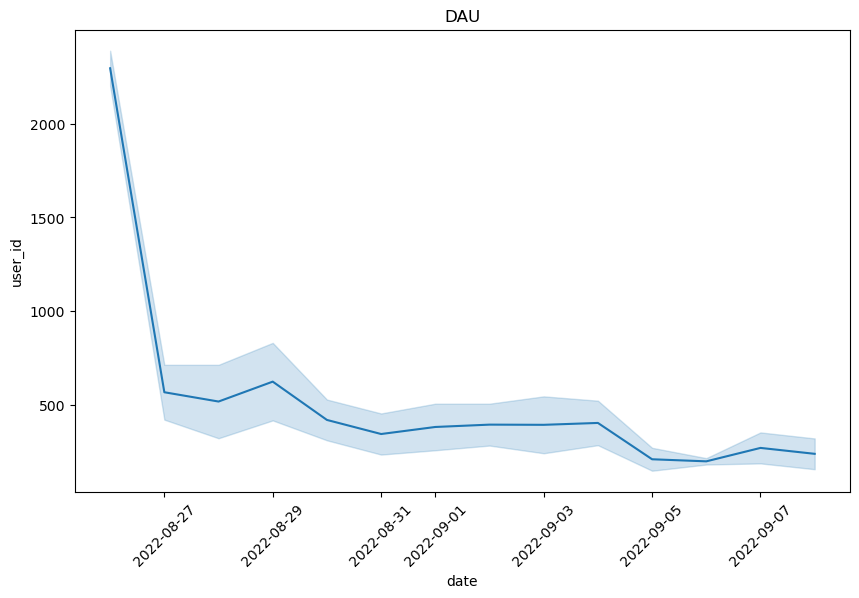

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=dau, x='date', y='user_id', ax=ax).set_title("DAU")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

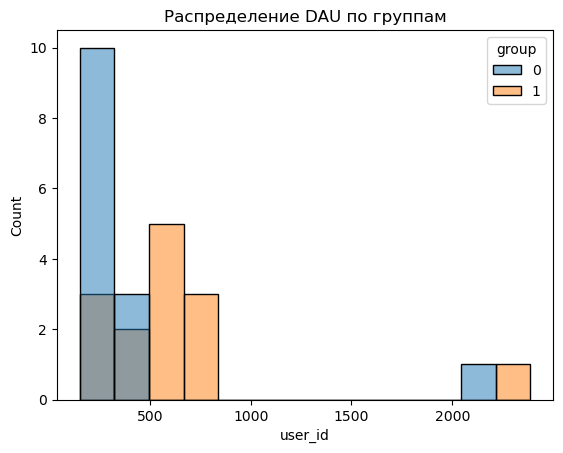

In [50]:
sns.histplot(x=dau.user_id, hue=dau.group).set_title(
    "Распределение DAU по группам")

In [51]:
pg.mwu(x=dau.query("group == 1").user_id, y=dau.query("group == 1").user_id)

,U-val,alternative,p-val,RBC,CLES
MWU,98.0,two-sided,1.0,0.0,0.5


В результате теста не удалось зафиксировать статзначимого изменения числа ежедневных пользователей продукта. В целом это неплохо и означает, что пользователей у нас осталось столько же


## Изменилось ли число товаров в корзине?


In [52]:
goods = all_data.groupby(['user_id', 'group'], as_index=0).agg({'order_id': 'count', 'product_id': 'nunique'})\
                .rename(columns={'order_id': 'order_count', 'product_id': 'unique_product_count'})
goods.head()

,user_id,group,order_count,unique_product_count
0,964,0,8,8
1,965,1,33,25
2,966,0,4,2
3,967,1,18,15
4,968,0,11,11


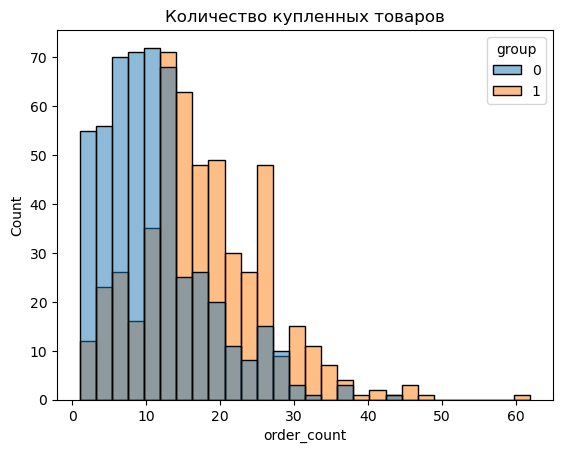

In [53]:
sns.histplot(x=goods.order_count, hue=goods.group).set_title(
    "Количество купленных товаров")

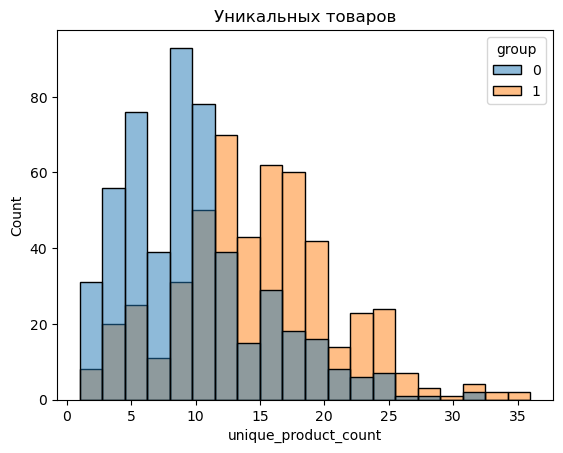

In [54]:
sns.histplot(x=goods.unique_product_count,
             hue=goods.group).set_title("Уникальных товаров")

In [55]:
pg.ttest(x=goods.query("group == 1").order_count,
         y=goods.query("group==0").order_count)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,13.589474,966.685518,two-sided,1.276872e-38,"[5.72, 7.66]",0.854497,2.195e+35,1.0


Число товаров в корзине пользователя в тестовой группе значимо увеличилось на 5.72-7.66


In [56]:
pg.ttest(x=goods.query("group == 1").unique_product_count,
         y=goods.query("group==0").unique_product_count)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.163834,993.094643,two-sided,1.289680e-41,"[4.44, 5.86]",0.889754,1.706e+38,1.0


Число уникальных товаров в корзине пользователя в тестовой группе значимо увеличилось на 4.44-5.86


## Аналитическое заключение: стоит ли внедрять новую систему рекомендаций?

Благодаря новой системе рекомендаций товаров удалось значительно повысить средний чек пользователя в диапазоне от 549.71 до 769.93. При этом количество отмен заказов и ежедневное количество активных пользователей (DAU) статистически не изменились, что свидетельствует о сохранении покупательского состава.

Кроме того, число товаров в корзине пользователя в тестовой группе значимо увеличилось на 5.72-7.66, а количество уникальных товаров в корзине возросло на 4.44-5.86.

### Заключение

Эти результаты показывают, что новая система рекомендаций эффективно стимулирует пользователей к увеличению количества и разнообразия покупок, не оказывая негативного влияния на удержание клиентов и стабильность их активности. Учитывая значительное увеличение среднего чека и расширение ассортимента покупок, мы рекомендуем внедрить новую систему рекомендаций.
